<a href="https://colab.research.google.com/github/jiobu1/DS-Unit-2-Kaggle-Challenge/blob/master/Jisha_Obukwelu_DSPT3_221_Kaggle_Challenge_1_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 1*

---

# Decision Trees

## Assignment
- [x] [Sign up for a Kaggle account](https://www.kaggle.com/), if you don’t already have one. Go to our Kaggle InClass competition website. You will be given the URL in Slack. Go to the Rules page. Accept the rules of the competition.
- [x] Do train/validate/test split with the Tanzania Waterpumps data.
- [x] Begin with baselines for classification.
- [x] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [x] Get your validation accuracy score.
- [x] Get and plot your feature importances.
- [x] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [x] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [x] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [x] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [x] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this classification problem, you may want to use the parameter `logistic=True`, but it can be slow.

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```


In [228]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [229]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

###1. Do train/validate/test split with the Tanzania Waterpumps data.

Changing status_group to numbers just to make visualization easier, may change back later.

In [0]:
train['status_group'] = train['status_group'].replace({'functional':2, 'functional needs repair':1, 'non functional':0})

In [231]:
#Split train into train & val
train, val = train_test_split(train, train_size=0.80, 
                              test_size=0.20, 
                              stratify=train['status_group'], 
                              random_state=42)
train.shape, val.shape, test.shape

((47520, 41), (11880, 41), (14358, 40))

###2.Begin with baselines for classification

In [232]:
train['status_group'].value_counts(normalize=True)

2    0.543077
0    0.384238
1    0.072685
Name: status_group, dtype: float64

My baseline is 54% for the majority class. 

###3a. Data Exploration

In [233]:
train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
56033,61234,300.0,2011-03-31,Dhv,264,DWE,36.948015,-7.707203,Mhuno,0,Rufiji,Kidatu A,Morogoro,5,3,Kilombero,Kidatu,80,True,GeoData Consultants Ltd,Company,Ikela Wa,True,1995,gravity,gravity,gravity,vwc,user-group,pay monthly,monthly,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,2
42149,3126,0.0,2011-04-14,NaN,0,NaN,33.852760,-8.828006,Kwa Mzee Ng'Ala,0,Rufiji,Majengo B,Mbeya,12,7,Mbarali,Igurusi,0,True,GeoData Consultants Ltd,WUA,NaN,True,0,gravity,gravity,gravity,wua,user-group,pay monthly,monthly,soft,good,insufficient,insufficient,river,river/lake,surface,communal standpipe,communal standpipe,2
50644,24396,0.0,2011-07-23,Lizad,0,LIZAD,33.026220,-2.726754,Nyashimb,0,Lake Victoria,Ukirigulu,Mwanza,19,7,Missungwi,Ukiriguru,0,NaN,GeoData Consultants Ltd,VWC,NaN,True,0,other,other,other,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,other,other,0
52777,42409,0.0,2011-02-21,W.B,66,DWE,39.050118,-7.624354,Mbembeni,0,Rufiji,Mkundi,Pwani,60,53,Rufiji,Bungu,234,True,GeoData Consultants Ltd,VWC,NaN,True,2010,other,other,other,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,other,other,0
44385,24656,0.0,2011-08-02,Private Individual,0,not known,32.441852,-2.323204,Kwa Adrian,0,Lake Victoria,Lugata Kati,Mwanza,19,5,Sengerema,Lugata,0,False,GeoData Consultants Ltd,Private operator,None,True,0,nira/tanira,nira/tanira,handpump,private operator,commercial,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,2


In [234]:
train.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,status_group
count,47520.000000,47520.000000,47520.000000,47520.000000,4.752000e+04,47520.000000,47520.000000,47520.000000,47520.000000,47520.000000,47520.000000
mean,37134.812626,307.815775,669.906902,34.059500,-5.709674e+00,0.432008,15.304777,5.613279,179.763279,1299.188384,1.158838
std,21463.691950,2581.547359,694.199942,6.583092,2.947016e+00,11.307413,17.552951,9.616923,458.794161,952.084263,0.949792
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,18552.500000,0.000000,0.000000,33.080643,-8.552563e+00,0.000000,5.000000,2.000000,0.000000,0.000000,0.000000
50%,37148.500000,0.000000,370.000000,34.895754,-5.027486e+00,0.000000,12.000000,3.000000,25.000000,1986.000000,2.000000
75%,55702.250000,20.000000,1322.000000,37.162157,-3.325511e+00,0.000000,17.000000,5.000000,214.000000,2004.000000,2.000000
max,74247.000000,250000.000000,2628.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,11463.000000,2013.000000,2.000000



#### What columns are duplicates, or nearly duplicates? 

After some preliminary exploration, I see that there are several columns with identical or near identical information. 
- water_point_type and water_point_type_group
- water_quality and quality_group
- source and source_type
- payment and payment_type
- extraction_type and extraction_type_group
- extraction_type_class is only different that handpumps have specific names
- schema_management and management

I will drop columns that have similar or near similar information.

In [235]:
print(train['waterpoint_type'].value_counts(),'\n', train['waterpoint_type_group'].value_counts())

communal standpipe             22837
hand pump                      13974
other                           5111
communal standpipe multiple     4874
improved spring                  628
cattle trough                     91
dam                                5
Name: waterpoint_type, dtype: int64 
 communal standpipe    27711
hand pump             13974
other                  5111
improved spring         628
cattle trough            91
dam                       5
Name: waterpoint_type_group, dtype: int64


In [236]:
print(train['water_quality'].value_counts(),'\n', train['quality_group'].value_counts())

soft                  40656
salty                  3844
unknown                1525
milky                   647
coloured                400
salty abandoned         275
fluoride                156
fluoride abandoned       17
Name: water_quality, dtype: int64 
 good        40656
salty        4119
unknown      1525
milky         647
colored       400
fluoride      173
Name: quality_group, dtype: int64


The only difference is that good and soft seem to be used interchangeably and fluoride was separated out into fluoride and fluoride abandoned(?).

In [237]:
print(train['quantity'].value_counts(),'\n', train['quantity_group'].value_counts())

enough          26589
insufficient    12028
dry              5032
seasonal         3254
unknown           617
Name: quantity, dtype: int64 
 enough          26589
insufficient    12028
dry              5032
seasonal         3254
unknown           617
Name: quantity_group, dtype: int64


In [238]:
print(train['source'].value_counts(),'\n', train['source_type'].value_counts())

spring                  13572
shallow well            13454
machine dbh              8825
river                    7749
rainwater harvesting     1837
hand dtw                  724
lake                      624
dam                       523
other                     160
unknown                    52
Name: source, dtype: int64 
 spring                  13572
shallow well            13454
borehole                 9549
river/lake               8373
rainwater harvesting     1837
dam                       523
other                     212
Name: source_type, dtype: int64


- machine dbh and hand dtw = borehole
- river and lake = river\lake
- other and unknown = other

In [239]:
print(train['payment'].value_counts(),'\n', train['payment_type'].value_counts())

never pay                20279
pay per bucket            7184
pay monthly               6616
unknown                   6509
pay when scheme fails     3150
pay annually              2937
other                      845
Name: payment, dtype: int64 
 never pay     20279
per bucket     7184
monthly        6616
unknown        6509
on failure     3150
annually       2937
other           845
Name: payment_type, dtype: int64


In [240]:
print(train['extraction_type'].value_counts(),'\n', train['extraction_type_group'].value_counts(), '\n', train['extraction_type_class'].value_counts())

gravity                      21413
nira/tanira                   6530
other                         5164
submersible                   3827
swn 80                        2948
mono                          2269
india mark ii                 1905
afridev                       1410
ksb                           1139
other - rope pump              363
other - swn 81                 173
windmill                        88
india mark iii                  76
other - play pump               76
cemo                            72
walimi                          41
climax                          24
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64 
 gravity            21413
nira/tanira         6530
other               5164
submersible         4966
swn 80              2948
mono                2269
india mark ii       1905
afridev             1410
rope pump            363
other handpump       292
other motorpump       96
wind-powered          88
india mark iii        76
Name: e

In [241]:
print(train['scheme_management'].value_counts(),'\n', train['management'].value_counts())

VWC                 29397
WUG                  4139
Water authority      2520
WUA                  2339
Water Board          2192
Parastatal           1340
Company               866
Private operator      842
Other                 616
SWC                    81
Trust                  60
None                    1
Name: scheme_management, dtype: int64 
 vwc                 32402
wug                  5177
water board          2354
wua                  2046
private operator     1576
parastatal           1413
water authority       722
other                 678
company               553
unknown               448
other - school         88
trust                  63
Name: management, dtype: int64


#### Exploratory visualizations

Visualize the relationships between feature(s) and target.

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [243]:
fig = px.scatter_mapbox(train, lat='latitude', lon='longitude', color='status_group', opacity=0.1)
fig.update_layout(mapbox_style='stamen-terrain')
fig.show()

Explore relationship between functional status and latitude and longitude

#####Exploratory Visuals

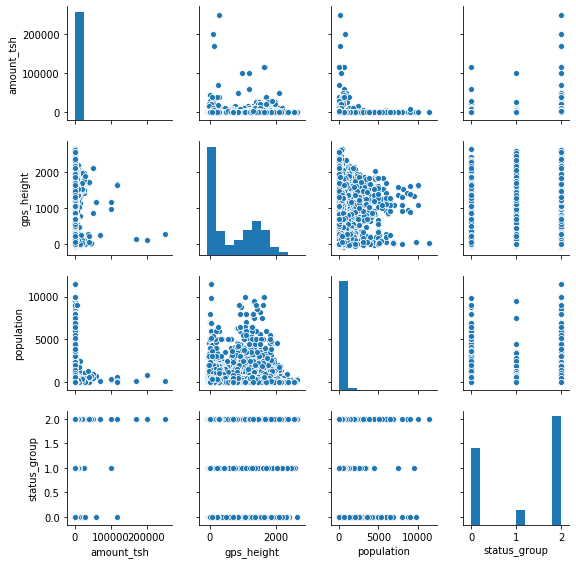

In [244]:
#Pairplot
cols = ['amount_tsh', 'gps_height', 'population', 'status_group']
sns.pairplot(train[cols], height=2)
plt.show()

#####Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features.
- Drop duplicate or nearly duplicate columns
- Can you extract the year from date_recorded? 
- Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?


In [0]:
import numpy as np

In [0]:
def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    cols_with_zeros = ['longitude', 'latitude', 'construction_year', 
                        'population', 'funder', 'installer']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
            
    # Drop duplicate columns
    duplicates = ['waterpoint_type', 'water_quality', 'quantity_group', 'source','payment_type', 'extraction_type','extraction_type_class', 'scheme_management']
    X = X.drop(columns=duplicates)
    
    # Drop recorded_by (all the same), id (can't glean useful info), num_private(mostly 0s)
    unused = ['recorded_by', 'num_private']
    X = X.drop(columns=unused)
    
    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded
    X['year_recorded'] = X['date_recorded'].dt.year
    
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years_till_check'] = X['year_recorded'] - X['construction_year']
    
    # return the wrangled dataframe
    return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [247]:
print(train.shape)
train.head()

(47520, 33)


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_name,permit,construction_year,extraction_type_group,management,management_group,payment,quality_group,quantity,source_type,source_class,waterpoint_type_group,status_group,year_recorded,years_till_check
56033,61234,300.0,2011-03-31,Dhv,264,DWE,36.948015,-7.707203,Mhuno,Rufiji,Kidatu A,Morogoro,5,3,Kilombero,Kidatu,80.0,True,Ikela Wa,True,1995.0,gravity,vwc,user-group,pay monthly,good,enough,river/lake,surface,communal standpipe,2,2011,16.0
42149,3126,0.0,2011-04-14,NaN,0,NaN,33.852760,-8.828006,Kwa Mzee Ng'Ala,Rufiji,Majengo B,Mbeya,12,7,Mbarali,Igurusi,NaN,True,NaN,True,NaN,gravity,wua,user-group,pay monthly,good,insufficient,river/lake,surface,communal standpipe,2,2011,NaN
50644,24396,0.0,2011-07-23,Lizad,0,LIZAD,33.026220,-2.726754,Nyashimb,Lake Victoria,Ukirigulu,Mwanza,19,7,Missungwi,Ukiriguru,NaN,NaN,NaN,True,NaN,other,vwc,user-group,never pay,good,insufficient,shallow well,groundwater,other,0,2011,NaN
52777,42409,0.0,2011-02-21,W.B,66,DWE,39.050118,-7.624354,Mbembeni,Rufiji,Mkundi,Pwani,60,53,Rufiji,Bungu,234.0,True,NaN,True,2010.0,other,vwc,user-group,never pay,good,insufficient,borehole,groundwater,other,0,2011,1.0
44385,24656,0.0,2011-08-02,Private Individual,0,not known,32.441852,-2.323204,Kwa Adrian,Lake Victoria,Lugata Kati,Mwanza,19,5,Sengerema,Lugata,NaN,False,None,True,NaN,nira/tanira,private operator,commercial,never pay,good,enough,shallow well,groundwater,hand pump,2,2011,NaN


In [248]:
train.describe(exclude='number').T.sort_values(by='unique')

,count,unique,top,freq,first,last
public_meeting,44842,2,True,40813,NaT,NaT
permit,45081,2,True,31087,NaT,NaT
source_class,47520,3,groundwater,36575,NaT,NaT
quantity,47520,5,enough,26589,NaT,NaT
management_group,47520,5,user-group,41979,NaT,NaT
waterpoint_type_group,47520,6,communal standpipe,27711,NaT,NaT
quality_group,47520,6,good,40656,NaT,NaT
source_type,47520,7,spring,13572,NaT,NaT
payment,47520,7,never pay,20279,NaT,NaT
basin,47520,9,Lake Victoria,8218,NaT,NaT


In [249]:
#null values to either impute or drop
train.isnull().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    2944
gps_height                   0
installer                 2956
longitude                 1459
latitude                  1459
wpt_name                     0
basin                        0
subvillage                 289
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population               17159
public_meeting            2678
scheme_name              22557
permit                    2439
construction_year        16602
extraction_type_group        0
management                   0
management_group             0
payment                      0
quality_group                0
quantity                     0
source_type                  0
source_class                 0
waterpoint_type_group        0
status_group                 0
year_recorded                0
years_ti

Looking at installer and funder it seems that both have a similar number of null values.

In [250]:
train['installer'].value_counts()

DWE                           13966
Government                     1465
RWE                             948
Commu                           860
DANIDA                          832
                              ...  
Arrian                            1
Seff Mtambo                       1
ELCA                              1
SAXON BUILDING CONTRACTORS        1
Mgaya                             1
Name: installer, Length: 1926, dtype: int64

In [251]:
train['funder'].value_counts()

Government Of Tanzania    7228
Danida                    2516
Hesawa                    1784
World Bank                1115
Rwssp                     1094
                          ... 
Misheni                      1
Masai Land                   1
Hilfe Fur Brunder            1
Pancrasi                     1
Mzee Mkungata                1
Name: funder, Length: 1697, dtype: int64

When comparing the two of the columns it seems that there are some similarities but not knowing enough, I am not dropping one or the other column. 

###3b. Select Features

In [252]:
train.dtypes

id                                int64
amount_tsh                      float64
date_recorded            datetime64[ns]
funder                           object
gps_height                        int64
installer                        object
longitude                       float64
latitude                        float64
wpt_name                         object
basin                            object
subvillage                       object
region                           object
region_code                       int64
district_code                     int64
lga                              object
ward                             object
population                      float64
public_meeting                   object
scheme_name                      object
permit                           object
construction_year               float64
extraction_type_group            object
management                       object
management_group                 object
payment                          object


In [253]:
# The status_group column is the target
target = 'status_group'

# Get a dataframe with all train columns except the target & id
train_features = train.drop(columns=[target])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.drop('id').tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features
print(len(features))

23


In [0]:
#Arrange data into X features matrix and y target vectors
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

###3b. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- Try other scikit-learn imputers. (Iterative imputer)

###4. Get your validation accuracy score.

In [0]:
from sklearn.pipeline import make_pipeline
import category_encoders as ce
from sklearn.impute import SimpleImputer

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [256]:
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    # IterativeImputer(add_indicator=False, estimator=None,
    #              imputation_order='ascending', initial_strategy='mean',
    #              max_iter=10, max_value=None, min_value=None,n_nearest_features=None,
    #              random_state=0, sample_posterior=False, tol=0.001,
    #              verbose=0),
    SimpleImputer(strategy='median'),
    DecisionTreeClassifier(min_samples_leaf=6, random_state=42)
)

#Fit on train
pipeline.fit(X_train, y_train)

#Score on train/val
print('Training Accuracy', pipeline.score(X_train, y_train))
print('Validation Accuracy', pipeline.score(X_val, y_val))

#Predict on Test Data
y_pred = pipeline.predict(X_test)

Training Accuracy 0.8647516835016835
Validation Accuracy 0.7681818181818182


In [0]:
assert all(X_train.columns == X_test.columns)

###5. Get and plot your feature importances.
 

In [258]:
model = pipeline.named_steps['decisiontreeclassifier']
model.feature_importances_

array([3.32172858e-02, 4.66573056e-02, 1.36218765e-01, 1.27429438e-01,
       1.34092009e-02, 1.72398714e-02, 3.60115775e-02, 2.65472325e-02,
       4.65396314e-03, 4.18964691e-02, 8.00197520e-04, 8.43057047e-04,
       5.71647720e-03, 7.53934994e-04, 2.44794321e-03, 5.47560344e-04,
       3.35888925e-03, 2.47955565e-03, 1.88509294e-03, 1.45904292e-03,
       0.00000000e+00, 2.96302549e-03, 7.84376753e-05, 3.80126417e-04,
       2.94411681e-05, 3.01132333e-04, 0.00000000e+00, 0.00000000e+00,
       3.14178313e-03, 6.03187420e-03, 4.73539316e-03, 3.73651726e-03,
       6.99094399e-05, 1.42211343e-05, 4.45696228e-04, 0.00000000e+00,
       9.55689908e-05, 2.73556283e-03, 1.80402156e-03, 9.91426523e-04,
       4.83873265e-03, 2.49771039e-03, 2.52246179e-03, 3.15800432e-03,
       3.41681337e-03, 3.01103145e-03, 1.08471166e-02, 5.66860063e-03,
       7.25359655e-03, 2.18893032e-03, 1.70602977e-03, 9.10469972e-03,
       7.01278126e-04, 3.63524037e-04, 0.00000000e+00, 4.51482544e-03,
      

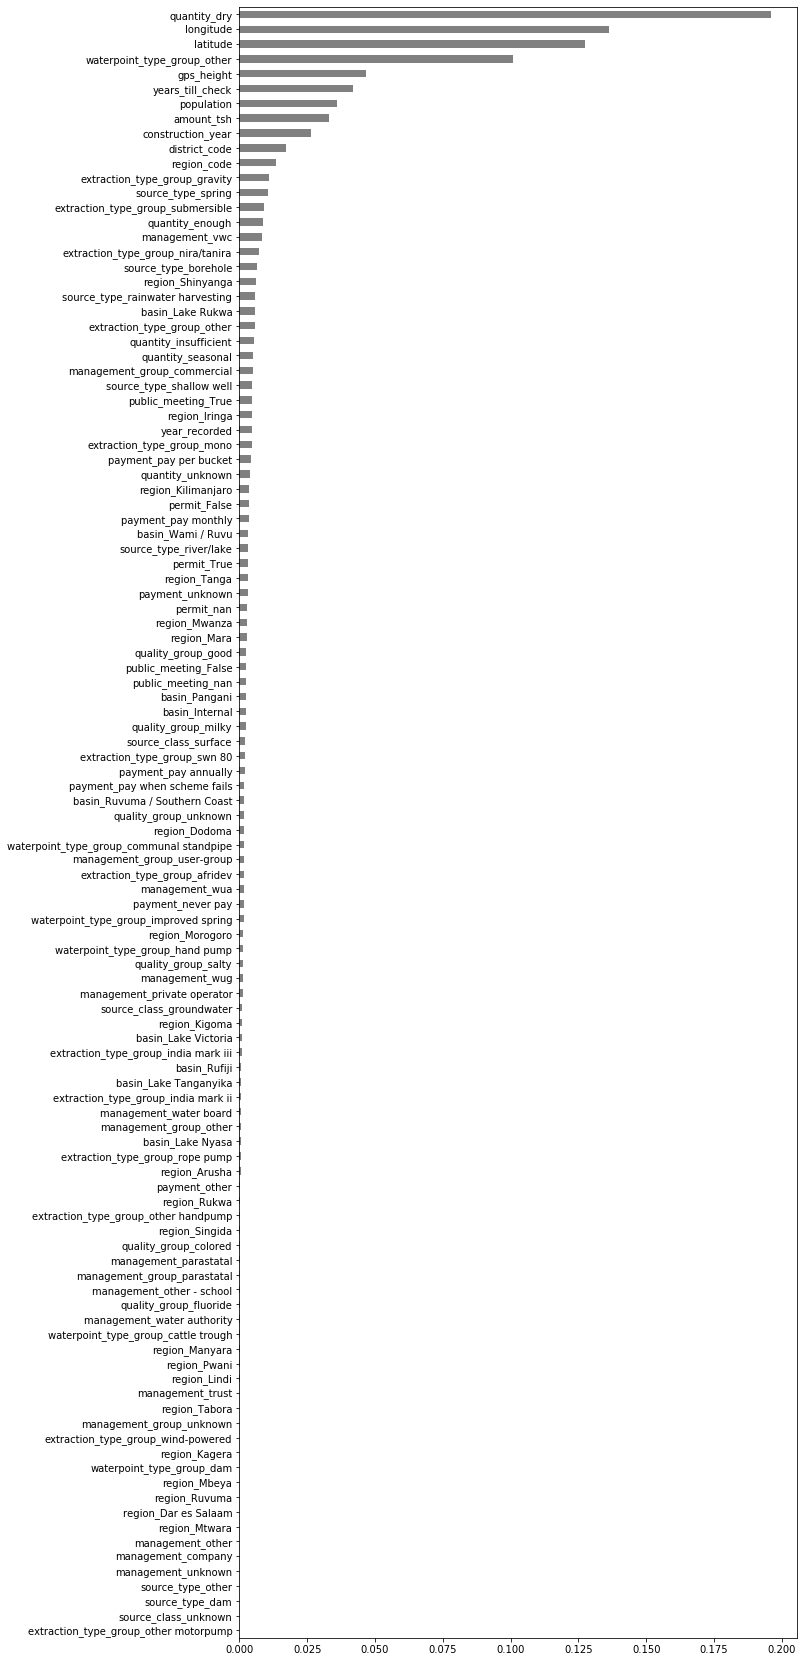

In [259]:
encoder = pipeline.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize=(10,30))
importances.sort_values().plot.barh(color='grey');

###6. Submit your predictions to our Kaggle competition.

In [0]:
#Write a submission csv file

submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('Obukwelu_DSPT3_Unit_2_submission1.csv', index=False)

In [0]:
# from google.colab import files
# files.download('Obukwelu_DSPT3_Unit_2_submission1.csv')

In [262]:
submission.head()

,id,status_group
0,50785,2
1,51630,2
2,17168,2
3,45559,0
4,49871,2


In [263]:
submission.shape

(14358, 2)